In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from distmetrics import compute_mahalonobis_dist_2d, get_asf_rtc_burst_ts, read_asf_rtc_image_data, despeckle_rtc_arrs_with_tv
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
from scipy.special import expit, logit
from distmetrics import load_trained_transformer_model, compute_transformer_zscore


References:

- CNN story: https://www.cnn.com/2024/05/25/world/video/damage-papua-new-guinea-landslide-ldn-digvid
- ASF Search: https://search.asf.alaska.edu/#/?polygon=POINT(143.3641%20-5.3821)&zoom=13.000&center=143.364,-5.425&resultsLoaded=true&granule=OPERA_L2_RTC-S1_T009-019294-IW2_20240603T084748Z_20240603T133726Z_S1A_30_v1.0&maxResults=250&dataset=OPERA-S1&productTypes=RTC

In [7]:
BURST_ID = 'T009_019294_IW2'

In [4]:
df_rtc_ts = get_asf_rtc_burst_ts(BURST_ID)
print('# of results: ', df_rtc_ts.shape[0])
df_rtc_ts.head()

# of results:  29


,opera_id,acq_datetime,polarization,url_vh,url_vv,track_number,geometry,dedup_id
0,OPERA_L2_RTC-S1_T009-019294-IW2_20231007T08475...,2023-10-07 08:47:51+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,9,"POLYGON ((143.32562 -5.40839, 143.3687 -5.3988...",OPERA_L2_RTC-S1_T009-019294-IW2_20231007T084751Z
1,OPERA_L2_RTC-S1_T009-019294-IW2_20231019T08475...,2023-10-19 08:47:51+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,9,"POLYGON ((143.32543 -5.40847, 143.36851 -5.398...",OPERA_L2_RTC-S1_T009-019294-IW2_20231019T084751Z
2,OPERA_L2_RTC-S1_T009-019294-IW2_20231031T08475...,2023-10-31 08:47:51+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,9,"POLYGON ((143.32647 -5.40917, 144.11392 -5.234...",OPERA_L2_RTC-S1_T009-019294-IW2_20231031T084751Z
3,OPERA_L2_RTC-S1_T009-019294-IW2_20231112T08475...,2023-11-12 08:47:51+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,9,"POLYGON ((143.32594 -5.40897, 144.11342 -5.234...",OPERA_L2_RTC-S1_T009-019294-IW2_20231112T084751Z
4,OPERA_L2_RTC-S1_T009-019294-IW2_20231124T08475...,2023-11-24 08:47:50+00:00,VV+VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,9,"POLYGON ((143.32749 -5.40822, 144.11495 -5.233...",OPERA_L2_RTC-S1_T009-019294-IW2_20231124T084750Z


**Warning**: sometime this cell fails and must be re-run due to a transient server error.

In [8]:
arrs_vv, profiles = read_asf_rtc_image_data(df_rtc_ts.url_vv.tolist())
arrs_vh, _ = read_asf_rtc_image_data(df_rtc_ts.url_vh.tolist())

Loading RTC data: 100%|████████████████████████| 29/29 [00:28<00:00,  1.01it/s]


In [9]:
arrs_vv_d = despeckle_rtc_arrs_with_tv(arrs_vv)
arrs_vh_d = despeckle_rtc_arrs_with_tv(arrs_vh)

100%|██████████████████████████████████████████| 29/29 [00:07<00:00,  4.50it/s]


In [10]:
for k, date in enumerate(df_rtc_ts.acq_datetime):
    print(k, date)

0 2023-10-07 08:47:51+00:00
1 2023-10-19 08:47:51+00:00
2 2023-10-31 08:47:51+00:00
3 2023-11-12 08:47:51+00:00
4 2023-11-24 08:47:50+00:00
5 2023-12-06 08:47:50+00:00
6 2023-12-18 08:47:49+00:00
7 2023-12-30 08:47:49+00:00
8 2024-01-11 08:47:48+00:00
9 2024-01-23 08:47:48+00:00
10 2024-02-04 08:47:47+00:00
11 2024-02-16 08:47:47+00:00
12 2024-02-28 08:47:47+00:00
13 2024-03-11 08:47:47+00:00
14 2024-03-23 08:47:48+00:00
15 2024-04-04 08:47:48+00:00
16 2024-04-16 08:47:48+00:00
17 2024-04-28 08:47:49+00:00
18 2024-05-22 08:47:48+00:00
19 2024-06-03 08:47:48+00:00
20 2024-06-15 08:47:48+00:00
21 2024-06-27 08:47:47+00:00
22 2024-07-09 08:47:47+00:00
23 2024-07-21 08:47:46+00:00
24 2024-08-02 08:47:46+00:00
25 2024-08-14 08:47:46+00:00
26 2024-08-26 08:47:46+00:00
27 2024-09-07 08:47:47+00:00
28 2024-09-19 08:47:47+00:00


In [11]:
pre_slice = slice(9, 19) # excludes last index
post_index = 19

In [12]:
transformer = load_trained_transformer_model()

In [13]:
pre_imgs_vv = arrs_vv_d[pre_slice]

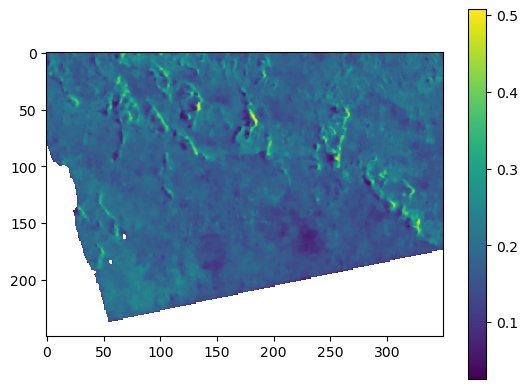

In [14]:
sy = np.s_[1250:1500]
sx = np.s_[400:750]
plt.imshow(pre_imgs_vv[0][sy, sx])
plt.colorbar()

In [34]:
pre_vv_c = [arr[sy, sx] for arr in arrs_vv_d[pre_slice]]
pre_vh_c = [arr[sy, sx] for arr in arrs_vh_d[pre_slice]]

post_vv_c = arrs_vv_d[post_index][sy, sx]
post_vh_c = arrs_vh_d[post_index][sy, sx]

In [35]:
dist_ob = compute_transformer_zscore(transformer, 
                                pre_vv_c,
                                pre_vh_c,
                                post_vv_c,
                                post_vh_c,
                                stride=2,
                                agg='max',
                                batch_size=256)

Chips Traversed: 100%|█████████████████████████| 78/78 [00:09<00:00,  7.95it/s]


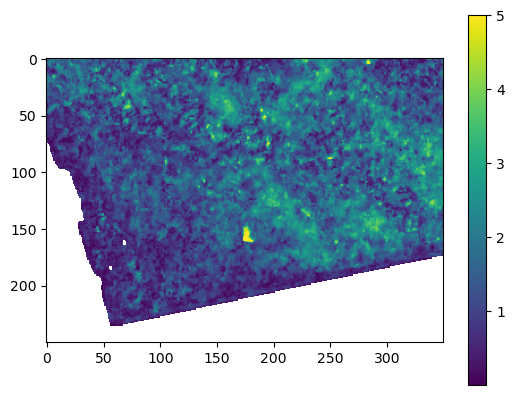

In [36]:
plt.imshow(dist_ob.dist, vmax=5)
plt.colorbar()

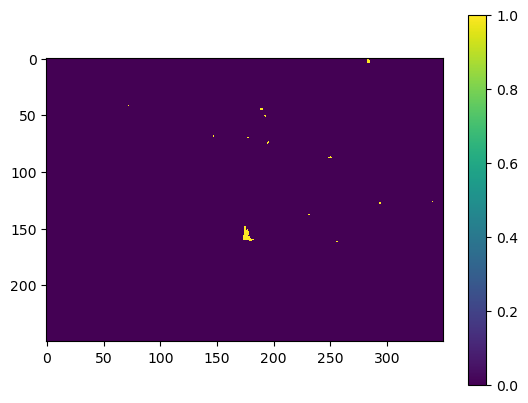

In [37]:
plt.imshow(dist_ob.dist > 4.5, vmax=1, interpolation='none')
plt.colorbar()

**Warninig**: the stat outputs of the function above are in `logits` NOT `gamma naught`. Hence `expit`!

<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_27511/301655645.py:3: SyntaxWarning: invalid escape sequence '\g'
  plt.title('Mean Estimate VV ($\gamma$)')


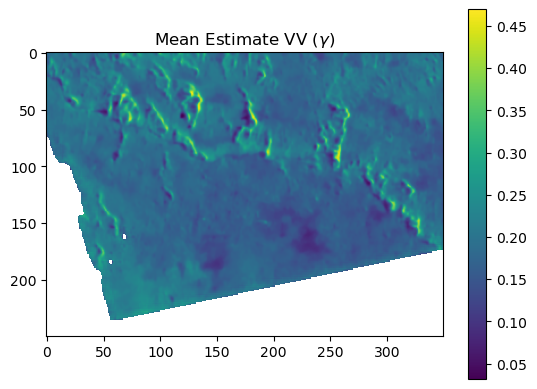

In [38]:
from scipy.special import expit

plt.title('Mean Estimate VV ($\gamma$)')
plt.imshow(expit(dist_ob.mean[0, ...]))
plt.colorbar()

Can't really apply `expit` to `sigma`...

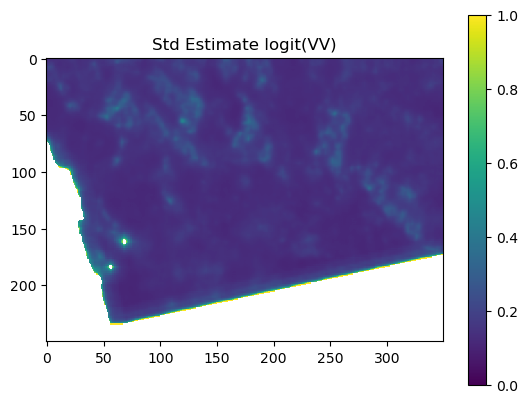

In [39]:
plt.title('Std Estimate logit(VV)')
plt.imshow(dist_ob.std[0, ...], vmax=1, vmin=0)
plt.colorbar()